In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib

timer = mypackage.Timer()

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[:4], X_test_orig[:4], Y_train_orig[:4], Y_test_orig[:4]
# channels_used = [7, 40, 68, 138, -1]
# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[..., channels_used], X_test_orig[..., channels_used], Y_train_orig[..., channels_used], Y_test_orig[..., channels_used]

# X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')
# # save the scaler to disk
# filename = 'latest_scaler_used.sav'
# joblib.dump(scaler, filename)
# # load the scaler from disk
# scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=True: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [3]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 3 # Each HybridSN takes 1 hour to run with m=3 and PCA->30
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=False)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=False)
#######################################################

X_train_HS.shape, X_test_HS.shape

((126, 56, 56, 208), (57, 56, 56, 208))

# Test HybridSN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

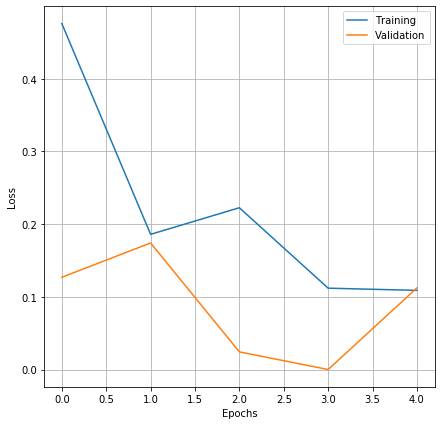

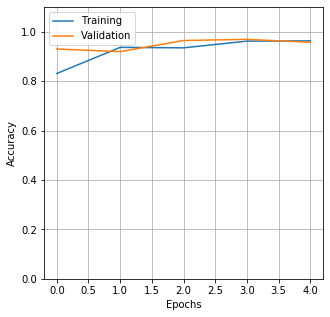

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     38469
         1.0       0.90      0.98      0.94     18652
         2.0       0.84      0.33      0.48      1247

    accuracy                           0.96     58368
   macro avg       0.91      0.76      0.80     58368
weighted avg       0.96      0.96      0.95     58368



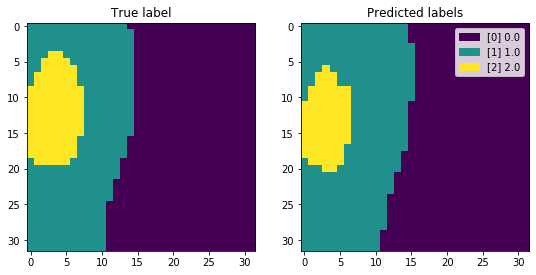

Elapsed time: 587.0667 seconds
Fasle positive blobs 22.
Fasle positive blobs per image 0.3860


In [4]:
model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
# model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
mypackage.report_count_false_positive(Y_hat, Y_test_HS)

In [3]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (570, 32, 32, 1) (1.6682685613632202, 73.80110931396484) (570, 32, 32, 208) (1260, 32, 32, 208)
(array([0., 1., 2.]), array([1067142,  208883,   14215]))
(array([0., 1., 2.]), array([459166, 117794,   6720]))


# Testing SVM

In [6]:
# Started the training at ~16:30
# Finished training at ~17:00

In [7]:
Y_train_orig.shape, Y_test_orig.shape, X_train_orig.shape

((42, 100, 100, 1), (19, 100, 100, 1), (42, 100, 100, 208))

Elapsed time: 3882.7281 seconds
Elapsed time: 3875.6876 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1068233
         1.0       0.95      0.97      0.96    208047
         2.0       0.95      0.61      0.74     13960

    accuracy                           0.99   1290240
   macro avg       0.97      0.86      0.90   1290240
weighted avg       0.99      0.99      0.99   1290240

Elapsed time: 1754.3790 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    459515
         1.0       0.97      0.96      0.97    117070
         2.0       0.95      0.70      0.81      7095

    accuracy                           0.99    583680
   macro avg       0.97      0.89      0.92    583680
weighted avg       0.99      0.99      0.99    583680

Fasle positive blobs 24.
Fasle positive blobs per image 0.0421


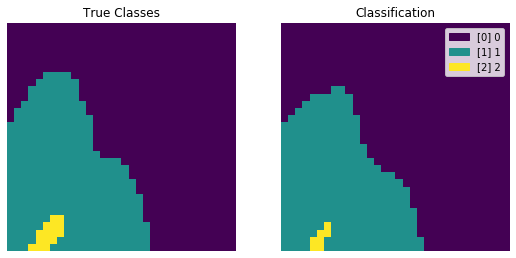

In [8]:
from sklearn import svm
from sklearn.metrics import classification_report

svm = mypackage.SVM(X_train_orig, Y_train_orig)
svm.train()
svm.predict(X_train, Y_train, plot=False)
Y_hat = svm.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

In [9]:
# mypackage.plot_labeled_images(Y_hat, Y_test_svm)

# Testing Logistic Regression

Elapsed time: 1613.7096 seconds
Elapsed time: 0.8090 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1068233
         1.0       0.96      0.96      0.96    208047
         2.0       0.93      0.69      0.79     13960

    accuracy                           0.99   1290240
   macro avg       0.96      0.88      0.92   1290240
weighted avg       0.99      0.99      0.99   1290240

Elapsed time: 0.3569 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    459515
         1.0       0.97      0.95      0.96    117070
         2.0       0.88      0.73      0.80      7095

    accuracy                           0.99    583680
   macro avg       0.95      0.90      0.92    583680
weighted avg       0.99      0.99      0.99    583680

Fasle positive blobs 124.
Fasle positive blobs per image 0.2175


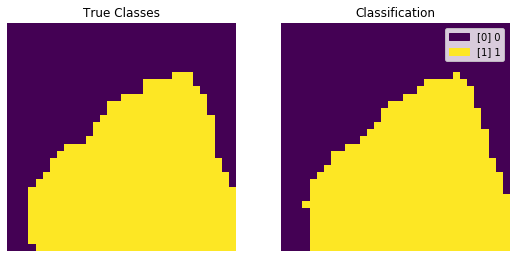

In [10]:
logreg = mypackage.LogReg(X_train_orig, Y_train_orig, C=1e5)# , max_iter=1000)
logreg.train()
logreg.predict(X_train, Y_train, plot=False)
Y_hat = logreg.predict(X_test, Y_test)

mypackage.report_count_false_positive(Y_hat, Y_test)

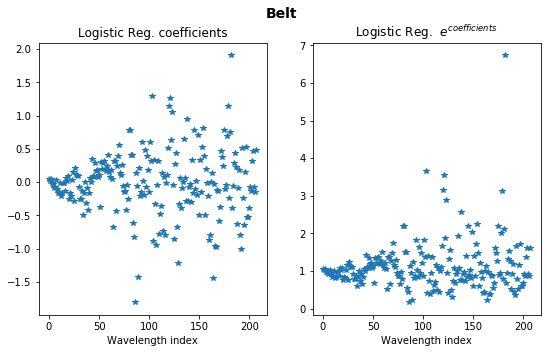

Ordered four most useful wavelengths are: [1584, 1299, 1364, 1361]nm
There corresponding indexes are: [182 103 121 120]


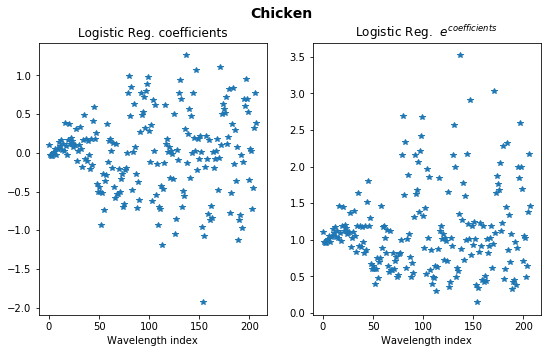

Ordered four most useful wavelengths are: [1422, 1545, 1458, 1216]nm
There corresponding indexes are: [137 171 147  80]


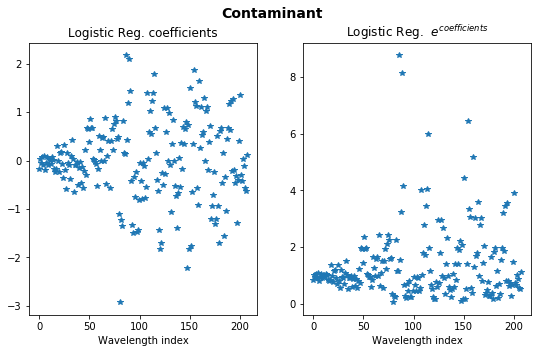

Ordered four most useful wavelengths are: [1238, 1249, 1483, 1339]nm
There corresponding indexes are: [ 86  89 154 114]


In [11]:
# logit(p) = log(p/(1-p)) = \beta_0 + \beta_1*w1+...+ \beta_209*w209
label = {0: 'Belt', 1: 'Chicken', 2: 'Contaminant'}
for i in range(3):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title('Logistic Reg. coefficients')
    plt.plot(logreg.classifier.coef_[i, :], '*')
    plt.xlabel("Wavelength index")
    plt.subplot(122)
    plt.title(r'Logistic Reg.  $e^{coefficients}$')
    exp_coef = np.exp(logreg.classifier.coef_[i, :])
    plt.plot(exp_coef, '*')
    plt.xlabel("Wavelength index")
#     plt.tight_layout()
    plt.suptitle(label[i], fontsize=14, fontweight='bold')
    plt.show()
    top_index = exp_coef.argsort()[-4:][::-1]
    print(f"Ordered four most useful wavelengths are: {[mypackage.Dataset.TOMRA_WAVELENGTHS[i] for i in top_index]}nm")
    print(f"There corresponding indexes are: {top_index}")

In [12]:
# mypackage.plot_labeled_images(Y_hat, Y_test)

In [13]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.3556 - accuracy: 0.9332
Epoch 00001: val_loss improved from inf to 0.14387, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 101s 89ms/sample - loss: 0.3548 - accuracy: 0.9334 - val_loss: 0.1439 - val_accuracy: 0.9776
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1273 - accuracy: 0.9700
Epoch 00002: val_loss improved from 0.14387 to 0.13680, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 98s 87ms/sample - loss: 0.1273 - accuracy: 0.9700 - val_loss: 0.1368 - val_accuracy: 0.9782
Epoch 3/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.9730
Epoch 00003: val_loss improved from 0.13680 to 0.07280, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 104s 92ms/sample - loss: 0.1017 - 

1130/1134 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9836
Epoch 00027: val_loss did not improve from 0.04801
1134/1134 [==============================] - 102s 90ms/sample - loss: 0.0458 - accuracy: 0.9837 - val_loss: 0.0526 - val_accuracy: 0.9825
Epoch 28/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0445 - accuracy: 0.9843
Epoch 00028: val_loss did not improve from 0.04801
1134/1134 [==============================] - 102s 90ms/sample - loss: 0.0447 - accuracy: 0.9843 - val_loss: 0.0577 - val_accuracy: 0.9803
Epoch 29/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0430 - accuracy: 0.9845
Epoch 00029: val_loss did not improve from 0.04801
1134/1134 [==============================] - 106s 93ms/sample - loss: 0.0431 - accuracy: 0.9844 - val_loss: 0.0545 - val_accuracy: 0.9823
Epoch 30/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9845
Epoch 00030: val_loss did not improve from 0.0480

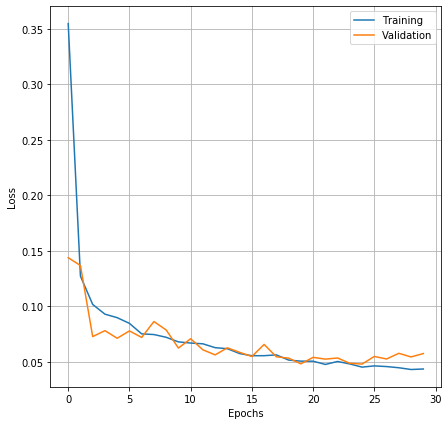

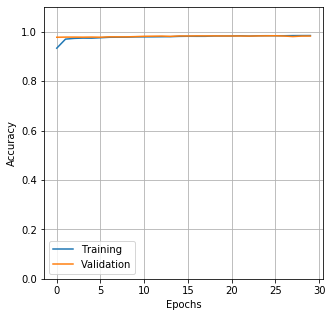

Predicting for train data
Elapsed time: 16.2709 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1067142
           1       0.95      0.97      0.96    208883
           2       0.81      0.65      0.72     14215

    accuracy                           0.99   1290240
   macro avg       0.92      0.87      0.89   1290240
weighted avg       0.99      0.99      0.99   1290240



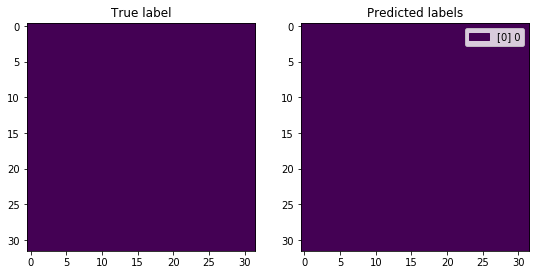

Predicting for test data
Elapsed time: 9.2582 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    459166
           1       0.96      0.96      0.96    117794
           2       0.75      0.64      0.69      6720

    accuracy                           0.99    583680
   macro avg       0.90      0.87      0.88    583680
weighted avg       0.98      0.99      0.98    583680



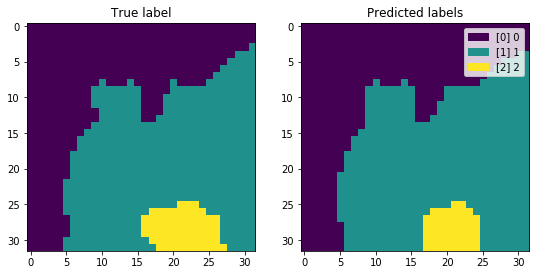

Elapsed time: 10.3564 seconds
Fasle positive blobs 51.
Fasle positive blobs per image 0.0895


In [7]:
spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.3949 - accuracy: 0.9123
Epoch 00001: val_loss improved from inf to 0.17717, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 144s 127ms/sample - loss: 0.3948 - accuracy: 0.9122 - val_loss: 0.1772 - val_accuracy: 0.9450
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1202 - accuracy: 0.9699
Epoch 00002: val_loss improved from 0.17717 to 0.16571, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 142s 125ms/sample - loss: 0.1200 - accuracy: 0.9700 - val_loss: 0.1657 - val_accuracy: 0.9509
Epoch 3/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9729
Epoch 00003: val_loss improved from 0.16571 to 0.14733, saving model to latest_spectral_unet.hdf5
1134/1134 [==============================] - 139s 123ms/sample - loss: 0.097

1130/1134 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9811
Epoch 00027: val_loss did not improve from 0.06961
1134/1134 [==============================] - 138s 122ms/sample - loss: 0.0572 - accuracy: 0.9811 - val_loss: 0.0804 - val_accuracy: 0.9780
Epoch 28/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0584 - accuracy: 0.9810
Epoch 00028: val_loss did not improve from 0.06961
1134/1134 [==============================] - 138s 122ms/sample - loss: 0.0582 - accuracy: 0.9810 - val_loss: 0.0784 - val_accuracy: 0.9776
Epoch 29/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9813
Epoch 00029: val_loss did not improve from 0.06961
1134/1134 [==============================] - 138s 122ms/sample - loss: 0.0570 - accuracy: 0.9813 - val_loss: 0.0762 - val_accuracy: 0.9784
Epoch 30/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0543 - accuracy: 0.9819
Epoch 00030: val_loss did not improve from 0.0

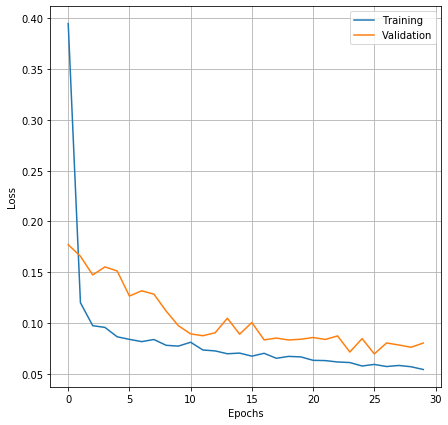

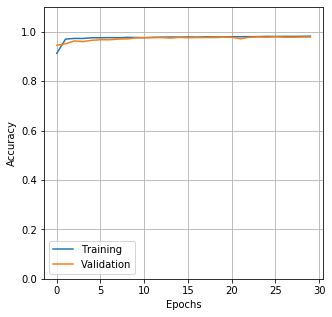

Predicting for train data
Elapsed time: 15.6657 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1067142
           1       0.94      0.95      0.95    208883
           2       0.96      0.11      0.20     14215

    accuracy                           0.98   1290240
   macro avg       0.96      0.69      0.71   1290240
weighted avg       0.98      0.98      0.98   1290240



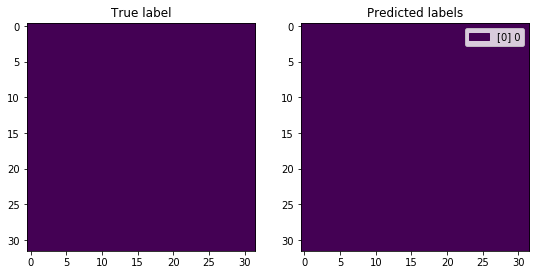

Predicting for test data
Elapsed time: 6.9592 seconds
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    459166
           1       0.95      0.95      0.95    117794
           2       0.97      0.18      0.30      6720

    accuracy                           0.98    583680
   macro avg       0.97      0.71      0.75    583680
weighted avg       0.98      0.98      0.97    583680



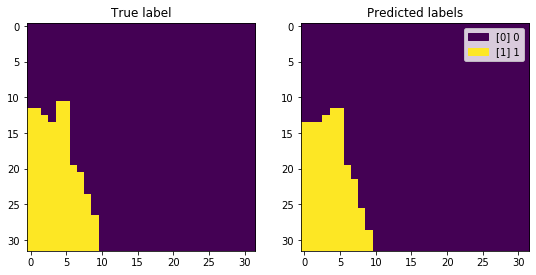

Elapsed time: 7.8395 seconds
Fasle positive blobs 0.
Fasle positive blobs per image 0.0000


In [5]:
# Max pooling
# spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
# print("Start training")
# timer.start()
# spectral_unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
# timer.stop()

# # spectral_unet.summary()
# spectral_unet.plot_training_results()
# print("Predicting for train data")
# spectral_unet.predict(X_train, Y_labels=Y_train)
# print("Predicting for test data")
# timer.start()
# y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
# timer.stop()
# mypackage.report_count_false_positive(y_pred_test, Y_test)

In [19]:
# spectral_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 208, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 32, 70, 8 512         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 70, 8 32          conv3d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 70, 8 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Test 2D UNet on the same data

(1260, 32, 32, 208)
Start training
Train on 1134 samples, validate on 126 samples
Epoch 1/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.4103 - accuracy: 0.8978
Epoch 00001: val_loss improved from inf to 0.25318, saving model to latest_unet.hdf5
1134/1134 [==============================] - 8s 7ms/sample - loss: 0.4109 - accuracy: 0.8975 - val_loss: 0.2532 - val_accuracy: 0.9730
Epoch 2/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9738
Epoch 00002: val_loss improved from 0.25318 to 0.17291, saving model to latest_unet.hdf5
1134/1134 [==============================] - 6s 6ms/sample - loss: 0.1197 - accuracy: 0.9738 - val_loss: 0.1729 - val_accuracy: 0.9783
Epoch 3/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.9736
Epoch 00003: val_loss improved from 0.17291 to 0.08475, saving model to latest_unet.hdf5
1134/1134 [==============================] - 6s 6ms/sample - loss: 0.0996 - accuracy: 0.973

Epoch 29/30
1125/1134 [============================>.] - ETA: 0s - loss: 0.0430 - accuracy: 0.9854
Epoch 00029: val_loss improved from 0.04879 to 0.04862, saving model to latest_unet.hdf5
1134/1134 [==============================] - 6s 6ms/sample - loss: 0.0428 - accuracy: 0.9854 - val_loss: 0.0486 - val_accuracy: 0.9837
Epoch 30/30
1130/1134 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9859
Epoch 00030: val_loss did not improve from 0.04862
1134/1134 [==============================] - 6s 5ms/sample - loss: 0.0412 - accuracy: 0.9859 - val_loss: 0.0605 - val_accuracy: 0.9825
Elapsed time: 202.6478 seconds


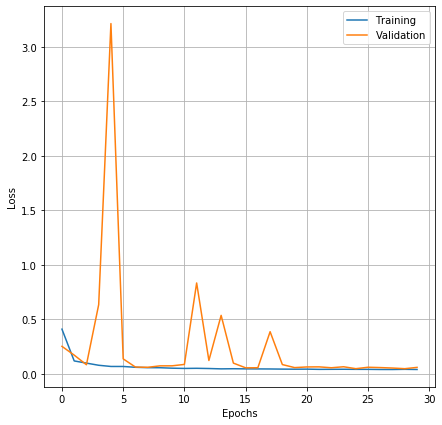

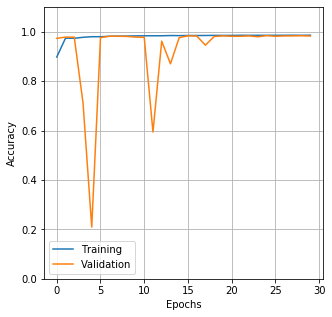

Predicting for train data
Elapsed time: 2.3922 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1067142
           1       0.95      0.97      0.96    208883
           2       0.93      0.50      0.65     14215

    accuracy                           0.99   1290240
   macro avg       0.96      0.82      0.87   1290240
weighted avg       0.99      0.99      0.99   1290240



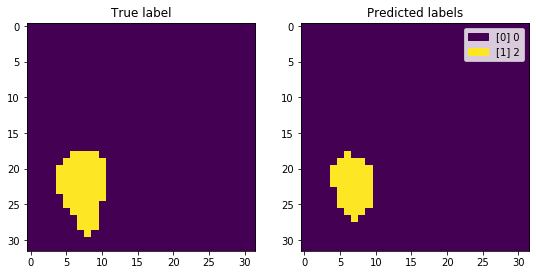

Predicting for test data
Elapsed time: 1.0230 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    459166
           1       0.97      0.96      0.96    117794
           2       0.88      0.58      0.70      6720

    accuracy                           0.99    583680
   macro avg       0.95      0.85      0.89    583680
weighted avg       0.98      0.99      0.98    583680



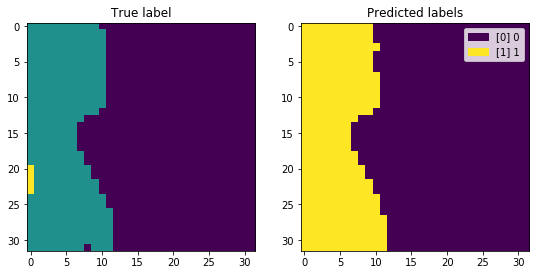

Elapsed time: 1.8970 seconds
Fasle positive blobs 13.
Fasle positive blobs per image 0.0228
Number of layers in the base model:  49


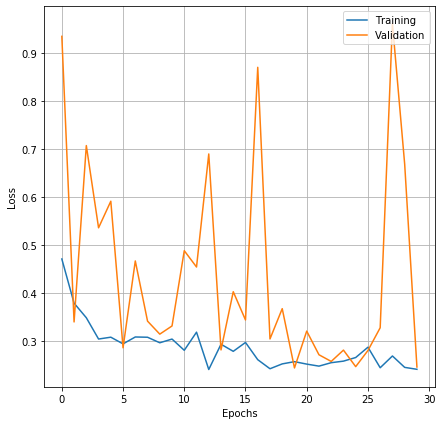

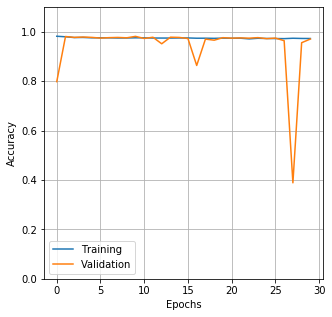

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 1.3192 seconds
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    459166
           1       0.99      0.86      0.92    117794
           2       0.62      0.83      0.71      6720

    accuracy                           0.97    583680
   macro avg       0.86      0.90      0.87    583680
weighted avg       0.97      0.97      0.97    583680



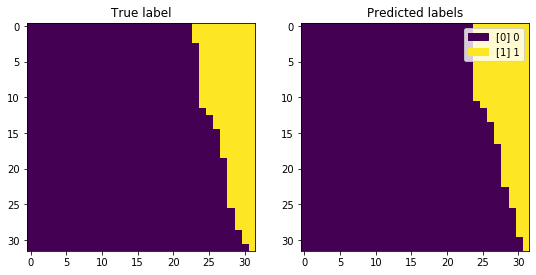

Fasle positive blobs 83.
Fasle positive blobs per image 0.1456


In [6]:
# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [] # [7, 40, 68, 138, -1]
def select_channels(X_train):
    if X_train.shape[-1] <= 30:
        return X_train
    elif channels_used != []:
        return X_train[..., channels_used]
    else:
        return X_train
    
print(select_channels(X_train).shape)
unet = mypackage.UNet(select_channels(X_train), Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
# TODO: Test this more: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU -> monitor='val_mean_io_u'
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=1)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(select_channels(X_train), Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(select_channels(X_test), Y_labels=Y_test);
timer.stop()
mypackage.report_count_false_positive(y_pred_test, Y_test)

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [16]:
# def get_classification_heat_map(y_hat, heat_maps):
#     heat = np.zeros(y_hat.shape)
#     heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
#     heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
#     heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
#     return heat

# def plot_with_heat_map(y_hat, heat_maps, y):
#     heat = get_classification_heat_map(y_hat, heat_maps)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(131)
#     plt.imshow(heat)
#     plt.colorbar()
#     plt.title("Model confidence of classification")
#     plt.subplot(132)
#     img = plt.imshow(y_hat)
#     mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
#     plt.title("Predicted labels")
#     plt.subplot(133)
#     img = plt.imshow(np.squeeze(y))
#     mypackage.Dataset._Dataset__add_legend_to_image(y, img)
#     plt.title("True labels")

# # y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
# for i in range(len(Y_test)):
#     if 2 in Y_test[i]:
#         plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
#         plt.suptitle(i)
        

Number of layers in the base model:  49


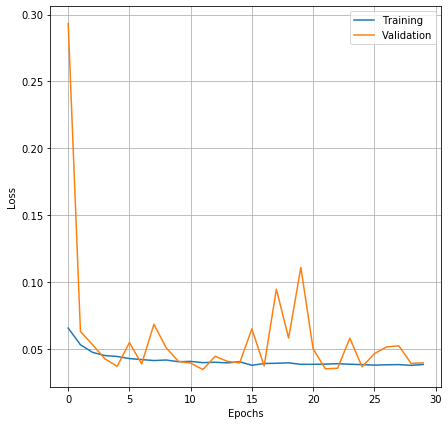

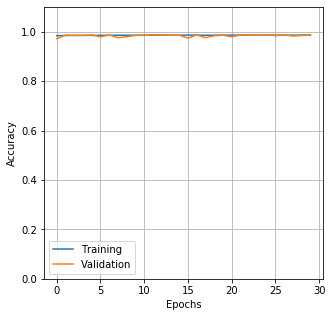

Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again
Elapsed time: 1.3574 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    459515
           1       0.98      0.94      0.96    117070
           2       0.77      0.81      0.79      7095

    accuracy                           0.98    583680
   macro avg       0.91      0.92      0.92    583680
weighted avg       0.98      0.98      0.98    583680



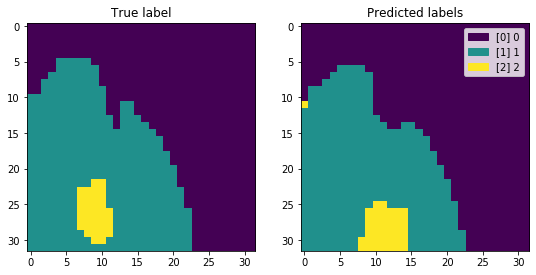

Fasle positive blobs 50.
Fasle positive blobs per image 0.0877


In [17]:
unet.retrain(select_channels(X_train), Y_train, batch_size=20, epochs=30, loss="categorical_crossentropy", validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after CategoricalCrossEntropy followed by Dice_Loss and then CategoricalCross again")
y_pred_test, y_pred_heat = unet.predict(select_channels(X_test), Y_labels=Y_test, return_heat_map=True);
mypackage.report_count_false_positive(y_pred_test, Y_test)

In [18]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))